# Reinforcement Learning Projeto Integrado - Quantum Finance



# Problema a ser solucionado através de Reinforcement Learning:

A Quantum Finance deseja criar um fundo automatizado para operar três ativos: Vale, Petrobrás e Brasil Foods. O objetivo é desenvolver e simular um agente de Reinforcement Learning (RL) capaz de tomar decisões financeiras, como compra, venda ou manutenção de posição, com base em dados históricos.

## Ambiente e Dados Financeiros
Vamos realizar a criação de um ambiente no Gymnasium chamado de TradingEnv.

Já para o fornecimento dos dados históricos financeiros das ações da Vale, Petrobrás e Brasil Foods, utilizamos a API da brapi, que disponibiliza dados históricos até o mais recente de diversas ações e com informações relevantes para nosso modelo. Porém, devido a chave necessária da API, extrai um csv. que está junto do arquivo zip. para subir em seu ambiente de execução para rodar o modelo.

### 1. Etapa de Coleta dos dados

In [ ]:
import numpy as np
import pandas as pd
import random
from collections import defaultdict
import gymnasium as gym
from gymnasium import spaces
import requests

In [ ]:
df_final = pd.read_csv('cotacoes.csv')

In [ ]:
df_final

,Date,date,open,high,low,close,volume,adjustedClose,ticker
0,2024-11-25 13:00:00,1732539600,58.18,58.56,58.12,58.17,17444500,57.6554,VALE3
1,2024-11-26 13:00:00,1732626000,58.29,58.49,57.15,57.43,21406600,56.9219,VALE3
2,2024-11-27 13:00:00,1732712400,57.87,58.42,57.60,58.13,22121200,57.6158,VALE3
3,2024-11-28 13:00:00,1732798800,57.90,58.80,57.27,57.53,20467000,57.0211,VALE3
4,2024-11-29 13:00:00,1732885200,58.25,59.21,58.15,58.78,31023600,58.2600,VALE3
...,...,...,...,...,...,...,...,...,...
178,2025-02-17 13:00:00,1739797200,20.08,20.10,19.52,19.52,4976700,19.5200,BRFS3
179,2025-02-18 13:00:00,1739883600,19.62,19.62,19.02,19.19,6461900,19.1900,BRFS3
180,2025-02-19 13:00:00,1739970000,19.05,19.25,18.84,19.03,5363800,19.0300,BRFS3
181,2025-02-20 13:00:00,1740056400,19.03,19.15,18.68,18.73,6125100,18.7300,BRFS3


### 2. Pré processamento dos dados

In [ ]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183 entries, 0 to 182
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           183 non-null    object 
 1   date           183 non-null    int64  
 2   open           183 non-null    float64
 3   high           183 non-null    float64
 4   low            183 non-null    float64
 5   close          183 non-null    float64
 6   volume         183 non-null    int64  
 7   adjustedClose  183 non-null    float64
 8   ticker         183 non-null    object 
dtypes: float64(5), int64(2), object(2)
memory usage: 13.0+ KB


In [ ]:
df_final = df_final.pivot(index='Date',columns='ticker', values=['adjustedClose'])

In [ ]:
df_final.head()

adjustedClose                  
ticker                      BRFS3    PETR4    VALE3
Date                                               
2024-11-25 13:00:00       24.7646  36.3243  57.6554
2024-11-26 13:00:00       24.2742  36.2780  56.9219
2024-11-27 13:00:00       24.4833  36.1482  57.6158
2024-11-28 13:00:00       24.3041  35.7773  57.0211
2024-11-29 13:00:00       24.7024  36.0647  58.2600

### 3. Etapa de definicação do Ambiente + Processamento nos Dados

Etapa de criação do Ambiente no Gymnasium.

Estado:
- Preço
- Média Móvel Curta (5 períodos)
- Média Móvel Longa (10 períodos)
- Quantidade de ativo atual
- Saldo disponível

Ação:
- Compra +1
- Venda -1
- Manter 0

Recompensa: Lucro imediato


In [ ]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np

class TradingEnv(gym.Env):
    def __init__(self, data, initial_balance=10000):
        """
        Ambiente de trading baseado em Reinforcement Learning.

        Parâmetros:
        - data: DataFrame contendo os preços históricos dos ativos
        - initial_balance: Quantia inicial em caixa
        """
        super(TradingEnv, self).__init__()

        self.data = data
        self.initial_balance = initial_balance
        self.current_step = 0
        self.num_assets = data.shape[1]

        # Estado: Preços, médias móveis e posição atual do portfólio
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf, shape=(self.num_assets * 3 + 1,), dtype=np.float32
        )

        # Ações: Comprar (+1), Vender (-1) ou Manter (0) para cada ativo
        self.action_space = spaces.Box(low=-1, high=1, shape=(self.num_assets,), dtype=np.int8)

        # Inicialização do portfólio
        self.reset()

    def reset(self):
        """
        Reseta o ambiente para um novo episódio.
        """
        self.current_step = 0
        self.balance = self.initial_balance
        self.asset_holdings = np.zeros(self.num_assets)
        self.done = False
        return self._next_observation()

    def _next_observation(self):
        """
        Retorna o estado atual do ambiente.
        """
        prices = self.data.iloc[self.current_step].values

        # Calcula médias móveis com tratamento para NaN
        moving_avg_short = self.data.rolling(window=5).mean().iloc[self.current_step].values
        moving_avg_long = self.data.rolling(window=10).mean().iloc[self.current_step].values
        momentum = self.data.pct_change().iloc[self.current_step].values

        # Substituir NaN por valores seguros
        moving_avg_short = np.nan_to_num(moving_avg_short, nan=prices)  # Usa preço como fallback
        moving_avg_long = np.nan_to_num(moving_avg_long, nan=prices)  # Usa preço como fallback
        momentum = np.nan_to_num(momentum, nan=0)  # Momentum inicial é zero por definição

        portfolio_info = np.append(self.asset_holdings, self.balance)
        state = np.concatenate((prices, moving_avg_short,moving_avg_long, momentum, portfolio_info))

        return state



    def step(self, action):
        """
        Executa uma ação e avança um passo no tempo.
        """
        # Processar ação
        prices = self.data.iloc[self.current_step].values
        for i in range(self.num_assets):
            if action[i] == 1:  # Compra
                if self.balance >= prices[i]:
                    self.asset_holdings[i] += 1
                    self.balance -= prices[i]
            elif action[i] == -1:  # Venda
                if self.asset_holdings[i] > 0:
                    self.asset_holdings[i] -= 1
                    self.balance += prices[i]

        # Avançar um dia
        self.current_step += 1
        if self.current_step >= len(self.data) - 1:
            self.done = True

        # Calcular recompensa (lucro do portfólio)
        new_prices = self.data.iloc[self.current_step].values
        portfolio_value = self.balance + np.sum(self.asset_holdings * new_prices)
        reward = portfolio_value - (self.balance + np.sum(self.asset_holdings * prices))

        return self._next_observation(), reward, self.done, {}

    def render(self):
        """
        Exibe informações do ambiente.
        """
        print(f"Step: {self.current_step}")
        print(f"Balance: {self.balance}")
        print(f"Holdings: {self.asset_holdings}")
        print(f"Portfolio Value: {self.balance + np.sum(self.asset_holdings * self.data.iloc[self.current_step].values)}")





### 4. Etapa de teste do ambiente

In [ ]:
# Criar instância do ambiente
env = TradingEnv(df_final)
# Resetar o ambiente para iniciar um episódio
state = env.reset()

# Exibir o estado inicial

state

array([   24.7646,    36.3243,    57.6554,    24.7646,    36.3243,
          57.6554,    24.7646,    36.3243,    57.6554,     0.    ,
           0.    ,     0.    ,     0.    ,     0.    ,     0.    ,
       10000.    ])

In [ ]:
# Rodar 10 passos de teste
for i in range(10):
    action = np.random.choice([-1, 0, 1], size=(env.num_assets,))  # Ações aleatórias para cada ativo
    next_state, reward, done, _ = env.step(action)

    print(f"\nPasso {i + 1}:")
    print("Ação tomada:", action)
    print("Recompensa recebida:", reward)
    env.render()  # Exibir estado atual do ambiente

    if done:
        break  # Para caso o episódio termine


Passo 1:
Ação tomada: [-1  1  0]
Recompensa recebida: -0.04629999999997381
Step: 1
Balance: 9963.6757
Holdings: [0. 1. 0.]
Portfolio Value: 9999.9537

Passo 2:
Ação tomada: [-1 -1  0]
Recompensa recebida: 0.0
Step: 2
Balance: 9999.9537
Holdings: [0. 0. 0.]
Portfolio Value: 9999.9537

Passo 3:
Ação tomada: [ 1 -1  1]
Recompensa recebida: -0.7739000000001397
Step: 3
Balance: 9917.8546
Holdings: [1. 0. 1.]
Portfolio Value: 9999.1798

Passo 4:
Ação tomada: [-1  1  0]
Recompensa recebida: 1.5262999999995372
Step: 4
Balance: 9906.3814
Holdings: [0. 1. 1.]
Portfolio Value: 10000.7061

Passo 5:
Ação tomada: [1 1 0]
Recompensa recebida: 0.9907000000002881
Step: 5
Balance: 9845.6143
Holdings: [1. 2. 1.]
Portfolio Value: 10001.6968

Passo 6:
Ação tomada: [ 1 -1  1]
Recompensa recebida: 1.6825000000008004
Step: 6
Balance: 9798.421299999998
Holdings: [2. 1. 2.]
Portfolio Value: 10003.379299999999

Passo 7:
Ação tomada: [ 0  0 -1]
Recompensa recebida: 1.5654999999987922
Step: 7
Balance: 9856.373999

## Definição do Agente Q-Learning

In [ ]:
class QLearningAgent:
    def __init__(self, env, learning_rate=0.1, discount_factor=0.95, epsilon=1.0, epsilon_decay=0.99, min_epsilon=0.05):
        """
        Agente Q-Learning para negociar ativos.

        Parâmetros:
        - env: O ambiente de negociação (TradingEnv).
        - learning_rate (α): O quanto o agente aprende em cada iteração.
        - discount_factor (γ): O peso das recompensas futuras.
        - epsilon: Probabilidade de exploração (ações aleatórias).
        - epsilon_decay: Fator de redução do epsilon ao longo do tempo.
        - min_epsilon: Valor mínimo de epsilon (para garantir exploração).
        """
        self.env = env
        self.alpha = learning_rate
        self.gamma = discount_factor
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.min_epsilon = min_epsilon

        # Inicializa a tabela Q com zeros
        self.q_table = {}
        self.rewards = []

    def get_q_values(self, state):
        """ Retorna os valores Q para um determinado estado. """
        return self.q_table.setdefault(tuple(state), np.zeros(self.env.action_space.shape[0]))

    def choose_action(self, state):
        """ Escolhe uma ação usando a estratégia ε-greedy. """
        if random.uniform(0, 1) < self.epsilon:
            return np.random.choice([-1, 0, 1], size=(self.env.num_assets,))  # Exploração (ação aleatória)
        else:
            q_values = self.get_q_values(state)
            return np.array([np.argmax(q_values[i]) - 1 for i in range(self.env.num_assets)])  # Exploração


    def update_q_table(self, state, action, reward, next_state):
        """ Atualiza a tabela Q conforme a equação do Q-Learning. """
        state_tuple = tuple(state)
        next_state_tuple = tuple(next_state)

        q_values = self.get_q_values(state)
        next_q_values = self.get_q_values(next_state)

        # Atualização Q-Learning
        for i in range(self.env.num_assets):
            q_values[i] = q_values[i] + self.alpha * (
                reward + self.gamma * np.max(next_q_values) - q_values[i]
            )

        self.q_table[state_tuple] = q_values

    def decay_epsilon(self):
        """ Reduz o epsilon para diminuir a exploração ao longo do tempo. """
        self.epsilon = max(self.min_epsilon, self.epsilon * self.epsilon_decay)

## Etapa de Treinamento

### 1. Treinamento do Agente no Ambiente Criado

In [ ]:
# Criar o ambiente e o agente
env = TradingEnv(df_final)
agent = QLearningAgent(env)

num_episodes = 200  # Quantidade de episódios de treinamento


for episode in range(num_episodes):
    state = env.reset()
    total_reward = 0

    done = False
    while not done:
        action = agent.choose_action(state)
        next_state, reward, done, _ = env.step(action)

        agent.update_q_table(state, action, reward, next_state)
        state = next_state
        total_reward += reward

    agent.rewards.append(total_reward)  # Salva a recompensa total do episódio
    agent.decay_epsilon()  # Reduz o epsilon ao longo do tempo

    print(f"🏆 Episódio {episode + 1} - Recompensa Total: {total_reward:.2f} - Epsilon: {agent.epsilon:.3f}")

🏆 Episódio 1 - Recompensa Total: 2.65 - Epsilon: 0.990
🏆 Episódio 2 - Recompensa Total: 29.22 - Epsilon: 0.980
🏆 Episódio 3 - Recompensa Total: 17.51 - Epsilon: 0.970
🏆 Episódio 4 - Recompensa Total: 20.66 - Epsilon: 0.961
🏆 Episódio 5 - Recompensa Total: -25.64 - Epsilon: 0.951
🏆 Episódio 6 - Recompensa Total: -25.24 - Epsilon: 0.941
🏆 Episódio 7 - Recompensa Total: -26.61 - Epsilon: 0.932
🏆 Episódio 8 - Recompensa Total: 1.22 - Epsilon: 0.923
🏆 Episódio 9 - Recompensa Total: -50.02 - Epsilon: 0.914
🏆 Episódio 10 - Recompensa Total: 0.97 - Epsilon: 0.904
🏆 Episódio 11 - Recompensa Total: -7.02 - Epsilon: 0.895
🏆 Episódio 12 - Recompensa Total: -21.67 - Epsilon: 0.886
🏆 Episódio 13 - Recompensa Total: -2.91 - Epsilon: 0.878
🏆 Episódio 14 - Recompensa Total: -22.34 - Epsilon: 0.869
🏆 Episódio 15 - Recompensa Total: 7.02 - Epsilon: 0.860
🏆 Episódio 16 - Recompensa Total: 16.57 - Epsilon: 0.851
🏆 Episódio 17 - Recompensa Total: -10.15 - Epsilon: 0.843
🏆 Episódio 18 - Recompensa Total: 3.6

### 2. Análise Gráfica

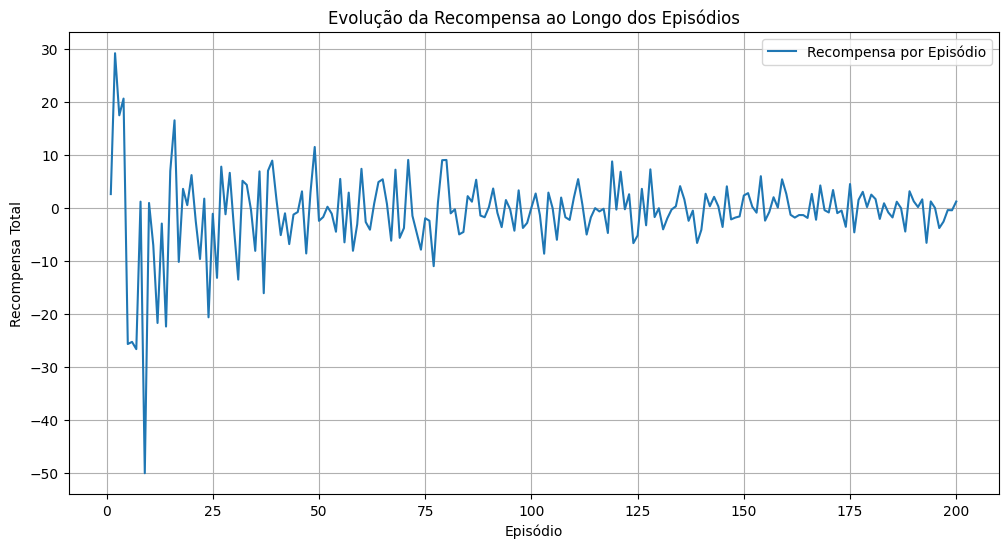

In [ ]:
import matplotlib.pyplot as plt

# Criar um gráfico da evolução das recompensas
plt.figure(figsize=(12,6))
plt.plot(range(1, len(agent.rewards) + 1), agent.rewards, label="Recompensa por Episódio")
plt.xlabel("Episódio")
plt.ylabel("Recompensa Total")
plt.title("Evolução da Recompensa ao Longo dos Episódios")
plt.legend()
plt.grid()
plt.show()
